In [16]:
# Import required libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Read the CSV file
df = pd.read_csv("lfw_arnie_nonarnie.csv")
print(df.head())

seed = 21

          0         1         2         3         4         5         6  \
0 -2.061987  0.581320 -0.249115 -0.631340 -1.359899  0.751619 -0.029364   
1 -0.796838 -0.667228 -0.107889  0.019755 -0.686348  0.912779  0.463412   
2  5.376779  1.142695  2.543111 -2.727212  0.272785 -0.972187  1.111221   
3  7.029235  1.242883 -2.628079  1.224479 -1.141370 -1.620647  0.205890   
4  5.484822  6.752706 -4.291114  1.740412 -1.603087 -1.075175  1.919936   

          7         8         9  ...       141       142       143       144  \
0  1.610456  0.341402  1.286709  ... -0.356844 -0.016488 -0.228473  0.258134   
1 -0.238308 -0.294023  0.215470  ... -0.037243 -0.012105 -0.351285 -0.034968   
2  1.645502 -2.556968 -0.648781  ...  0.157441 -0.333875 -0.303720 -0.085975   
3  1.567561  0.736200  0.010782  ...  0.051040 -0.068796  0.141841 -0.227999   
4 -0.197615  1.030596  1.451936  ...  0.034412  0.265141  0.226000  0.032064   

        145       146       147       148       149  Label  
0  0.04

The dataset contains data that is already standardized and has had its dimension reduced using Principal Component Analysis. Therefore, we can jump right into the modeling.

In [17]:
# Seperate the predictor and class label
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data into training and testing sets using stratify to balance the class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

This project calls for pipelines for three classification models. The three that I have chosen are Logistic Regression, K-Neighbors Classifier, and Decision Tree Classifier.

In [18]:
# Instantiate classification models
models = {
    'Logistic Regression': LogisticRegression(random_state=seed),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=seed)
}

# Create parameter grid for Cross Validation & Hyperparameter Tuning
param_grid = [
    {
        'classifier': [LogisticRegression(random_state=seed)],
        'classifier__C': np.arange(0.001, 1.1, 0.1)
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': np.arange(1, 25, 3)
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=seed)],
        'classifier__max_depth': [None, 10, 20]
    }
]

# Cross Validation
kf = KFold(n_splits=5, random_state=seed, shuffle=True)

# Create blank dictionary to store model results
best_models= {}

Now that the models, parameters, and cross validation is all instantiated, we can loop the pipelines for each model and its varying parameters to determine which model and its parameters perform the best.

The metric of interest for this project is accuracy, so we'll use the grid_search.best_score_ value to find the model's accuracy.

In [19]:
for model_name, model in models.items():
    steps = [
        ('scaler', StandardScaler()),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(pipeline, param_grid, cv=kf)
    grid_search.fit(X_train, y_train)
    print(grid_search)

    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"{model_name}: Best Parameters: {grid_search.best_params_}, Best CV Score: {grid_search.best_score_}")

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(random_state=21))]),
             param_grid=[{'classifier': [LogisticRegression(C=0.201,
                                                            random_state=21)],
                          'classifier__C': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
       6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00])},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22])},
                         {'classifier': [DecisionTreeClassifier(random_state=21)],
                          'classifier__max_depth': [None, 10, 20]}])
Logistic Regression: Best Parameters: {'classifier': LogisticRegression(C=0.201, random_s

Next, we'll grab the best model and its score from our dictionary of results.

In [20]:
best_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
best_model_info = best_models[best_model_name]
best_model_cv_score = best_model_info['best_score']
best_model = best_model_info['best_estimator']
print(best_model)
print(best_model_cv_score)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=0.201, random_state=21))])
0.8019354838709678


We can see that the best model is a Logistic Regression classification model with an accuracy score of 80.19%.

Now we'll use this model on the test set.

In [21]:
new_model = best_model
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        30
           1       1.00      0.12      0.22         8

    accuracy                           0.82        38
   macro avg       0.91      0.56      0.56        38
weighted avg       0.85      0.82      0.75        38



The accuracy of this model on the test set appears to be 82%. Let's examine a confusion matrix.

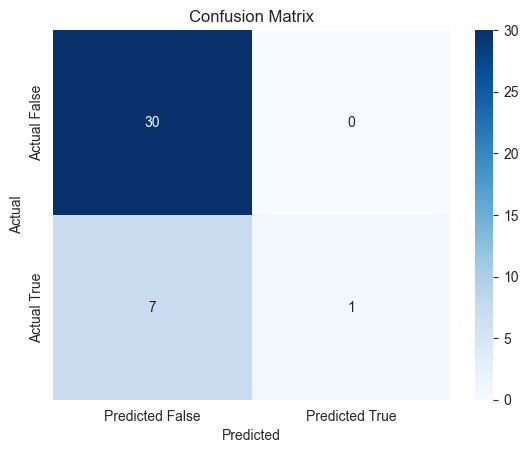

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)

TN = conf_matrix[0,0]
TP = conf_matrix[1,1]
FN = conf_matrix[1,0]
FP = conf_matrix[0,1]

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

And finally, let's print the score results.

In [23]:
accuracy = (TN + TP) / (TN + TP + FN + FP)
recall = TP / (FN + TP)
precision = TP / (FP + TP)
f1 = 2 * ((precision * recall) / (precision + recall))

acc_results = {
    'Model': [best_model_name],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
}

results_df = pd.DataFrame(acc_results)
print(results_df)

                 Model  Accuracy  Precision  Recall        F1
0  Logistic Regression  0.815789        1.0   0.125  0.222222


## Results
The best model is the Decision Tree with an accuracy score of 81.58%, which exceeds the 80% threshold. Based on the confusion matrix results, the model is great at predicting who is not Arnold. Given the 0.125 recall score, it isn't as accurate with identifying Arnold.